<a href="https://colab.research.google.com/github/tankgauravgt/sound-event-detection/blob/main/01.%20SED-Spec-IID-Fragments-Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install dependencies:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install tensorflow             >> /dev/null
!pip install matplotlib             >> /dev/null
!pip install sklearn                >> /dev/null
!pip install librosa                >> /dev/null 
!pip install pandas                 >> /dev/null
!pip install numpy                  >> /dev/null
!pip install bpmll                  >> /dev/null
!pip install tqdm                   >> /dev/null

### Download the Dataset:

In [3]:
!wget -q https://raw.githubusercontent.com/tankgauravgt/sound-event-detection/main/download_dataset.py && (python download_dataset.py; rm download_dataset.py)
!unzip -q event_detection.zip
!mv event_detection/dataset .
!rm event_detection.zip

### Loading libraries:

In [1]:
from IPython.display import Audio
import matplotlib.pyplot as plt
import librosa.display as lrd
from bpmll import bp_mll_loss
import tensorflow as tf
import librosa as lr
import pandas as pd
import numpy as np
import matplotlib
import random
import tqdm
import os

### Matplotlib params:

In [2]:
# matplotlib.style.use('seaborn')
# plt.rcParams["figure.figsize"] = (12, 12)

### Setting the seed values:

In [3]:
np.random.seed(5)
tf.random.set_seed(5)

### Loading the dataset:

In [4]:
db_root = './dataset'

In [5]:
dataset = pd.read_csv(db_root + '/meta.csv', sep='\t')

In [6]:
files = sorted(set(dataset['filename']))
events = sorted(set(dataset['event_label']) | set(['Silence']))

In [7]:
e2i = {events[i]: i for i in range(11)}
i2e = {i: events[i] for i in range(11)}

### Create Spectrogram:

In [8]:
hparams = {
    "n_fft": 8000,
    "hop_size": 441,
    "srate": 44100,
    "n_mels": 256
}

In [9]:
def create_feature_image(y, hparams):
    # create spectrogram:
    spec = lr.feature.melspectrogram(
        y=y,
        sr=hparams['srate'],
        n_fft=hparams['n_fft'],
        hop_length=hparams['hop_size'],
        n_mels=hparams['n_mels'],
        power=1
    )
    
    # normalized feature image:
    spec = lr.amplitude_to_db(
        np.abs(spec), 
        ref=np.max
    )
    
    # return log cropped, normalized feature image:
    return spec[0:hparams['n_fft'] // 2, 0:y.shape[0] // hparams['hop_size']]

In [10]:
def process_file(path, hparams, inference_mode=False):
    # read audio file:
    y, sr = lr.load(path, sr=44100)
    
    # trim samples to 10 seconds:
    y = y[0:441000]

    if len(y) < 441000:
        y = np.hstack([y, np.zeros(441000 - len(y))])

    # create spectrogram:
    spec = create_feature_image(y, hparams)
    
    if not inference_mode:
        # multihot response vectors for each segment:
        response_vector = np.zeros((1000, 11))
        response_vector[:, e2i['Silence']] = 1
        
        # extract events using metadata file:
        labelled_events = dataset[dataset['filename'] == file].to_numpy()
        
        # marking all events:
        for event in labelled_events:
            init = round(event[1] / 0.01)
            last = round(event[2] / 0.01)
            response_vector[init:last, e2i[event[3]]] = 1
            response_vector[init:last, e2i['Silence']] = 0
            
        return {
            'data': y,
            'sr': 44100,
            'target': response_vector,
            'mel_spec': spec[::-1, :]
        }
    else:
        return {
            'data': y,
            'sr': 44100,
            'mel_spec': spec[::-1, :]
        }

### Create features from audio files:

In [11]:
# cache this (recommended):
cached = True

examples = []
if not cached:
    for file in tqdm.tqdm(files, desc='files processed:'):
        examples += [process_file(db_root + '/samples/' + file, hparams)]
    np.save('drive/MyDrive/Storage/examples_256.npy', examples, allow_pickle=True)
else:
    examples = np.load('drive/MyDrive/Storage/examples_256.npy', allow_pickle=True)

### Visualizing the examples:

In [12]:
def visualize_example(example, events_only=False):
    
    nx = None
    height = None
    height_ratios = None
    if events_only == True:
        nx = 11
        height = 12
        height_ratios = [0.25] * 11
    else:
        nx = 13
        height = 15
        height_ratios = [0.75, 3] + [0.25] * 11

    # plot in time-domain mode:
    ff, aa = plt.subplots(
        nx, 
        1, 
        figsize=[12, height], 
        gridspec_kw={
            'height_ratios': height_ratios
        }
    )

    if not events_only:    
        # plot time-domain:
        aa[0].plot(np.linspace(0, 1000, 441000), example['data'])
        aa[0].set_xlim([0, 1000])
        
        # plot freq-domain:
        aa[1].imshow(
            example['mel_spec'], 
            cmap='plasma', 
            aspect='auto'
        )
        aa[1].set_xlim([0, 1000])

        # plot events:
        for c in range(11):
            aa[c+2].plot(example['target'][:, c])
            aa[c+2].set_xlim([0, 1000])
            aa[c+2].set_ylim([-0.5, 1.5])
            aa[c+2].set_title(f'{i2e[c]}')
            aa[c+2].set_yticks([])
    else:
        # plot events:
        for c in range(11):
            aa[c].plot(example['target'][:, c])
            aa[c].set_xlim([0, 1000])
            aa[c].set_ylim([-0.5, 1.5])
            aa[c].set_title(f'{i2e[c]}')
            aa[c].set_yticks([])
        
    plt.tight_layout()
    plt.show()

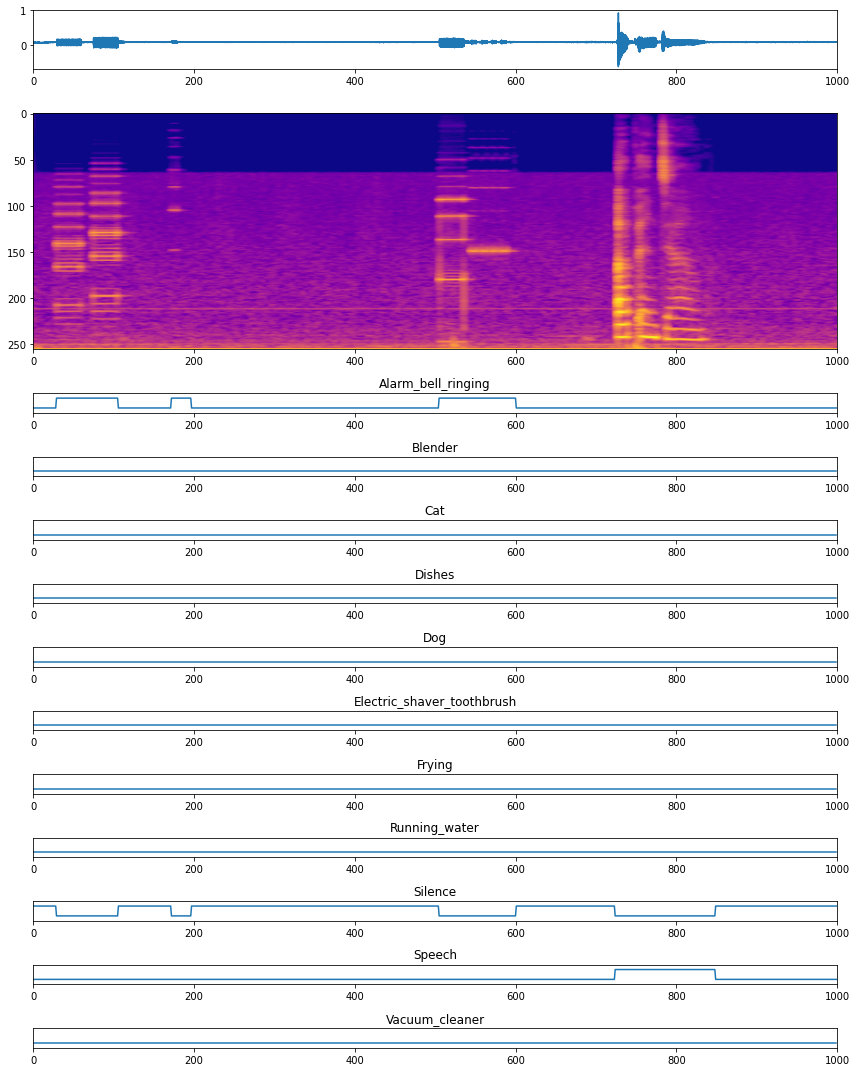

In [13]:
visualize_example(examples[0])

### Create Sequences:

In [14]:
def extract_segments(example, context, win_len=50, threshold=0.75):
    for i in range(0, 1000 - win_len, 5):
        label = np.nonzero((example['target'][i:i+50, :].mean(axis=0) > threshold))
        for c in label[0]:
            context[c] += [{
                'data': example['data'][i * hparams['hop_size']:(i+50) * hparams['hop_size']],
                'mel_spec': example['mel_spec'][:, i:i+50]
            }]

In [15]:
context = {i: [] for i in range(11)}

In [16]:
for example in tqdm.tqdm(examples[100::], desc='Examples processed:'):
    extract_segments(example, context)

Examples processed:: 100%|██████████| 1945/1945 [00:06<00:00, 301.51it/s]


In [17]:
for c in context.keys():
    print('Class: {}'.format(c), len(context[c]))

Class: 0 9755
Class: 1 22612
Class: 2 8759
Class: 3 4976
Class: 4 7165
Class: 5 19056
Class: 6 12818
Class: 7 11010
Class: 8 190593
Class: 9 35552
Class: 10 19981


### Generate Validation Set:

In [18]:
# Generate Validation Set:
vX, vY = [], []

# Collecting stratified 500 samples:
for i in range(500):
    for c in range(11):
        vX += [context[c][i]['mel_spec']]
        vY += [tf.keras.utils.to_categorical(c, 11)]

vX = np.array(vX)
vX = np.moveaxis(vX, 2, 1).reshape(-1, 50, 256, 1).repeat(3, 3)
vY = np.array(vY)

### Removing Validation Data from Collection:

In [19]:
for c in range(11):
    context[c] = context[c][500::]

### Generate Training Batches:

In [20]:
def generate_batch(context):

    indices = []
    for c in range(11):
        indices += [np.random.choice(len(context[c]), size=1000, replace=True)]

    # generate training batch:
    tX, tY = [], []
    
    for ex in range(1000):
        for c in range(11):
            tX += [context[c][indices[c][ex]]['mel_spec']]
            tY += [tf.keras.utils.to_categorical(c, 11)]
    
    # to numpy array:
    tX, tY = np.array(tX), np.array(tY)

    # reshaping the features:
    tX = np.moveaxis(tX, 2, 1).reshape(-1, 50, 256, 1).repeat(3, 3)

    return tX, tY

### Training and Validation Set:

In [21]:
class LoadBatchOnEpochEnd(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        global tX
        global tY
        tX, tY = generate_batch(context)

In [22]:
tX, tY = generate_batch(context)

### Loading CNN Model:

In [23]:
# vgg_19_base = tf.keras.applications.VGG19(include_top=False, input_shape=[50, 256, 3])
# vgg_19_base.trainable = False

vgg_16_base = tf.keras.applications.VGG16(include_top=False, input_shape=[50, 256, 3])
vgg_16_base.trainable = False

### Model Training:

In [24]:
model = tf.keras.Sequential()

In [25]:
model.add(vgg_16_base)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dense(11, activation='sigmoid'))

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=bp_mll_loss,
    metrics=[tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()]
)

In [106]:
tf.keras.models.save_model(model, filepath='drive/MyDrive/Storage/models/vgg16_sed', overwrite=True)

INFO:tensorflow:Assets written to: drive/MyDrive/Storage/models/vgg16_sed/assets


In [ ]:
hist = model.fit(tX, tY, callbacks=[LoadBatchOnEpochEnd()], validation_data=(vX, vY), epochs=1)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 11)                715       
                                                                 
Total params: 14,748,235
Trainable params: 33,547
Non-trainable params: 14,714,688
_________________________________________________________________


### Evaluation Metrics:

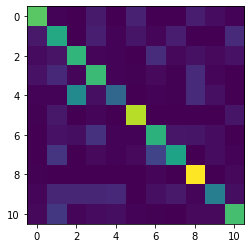

In [31]:
from sklearn.metrics import confusion_matrix

y_true = np.argmax(vY, axis=-1)
y_pred = np.argmax(model.predict(vX), axis=-1)

plt.imshow(confusion_matrix(y_true, y_pred));

In [32]:
from sklearn.metrics import f1_score

f1_score(y_true, y_pred, average='micro')

0.6367272727272727

### Prediction:

In [32]:
if not os.path.exists('./test'):
    os.mkdir('./test')

In [118]:
!zip test.zip ./test -r

  adding: test/ (stored 0%)
  adding: test/speech_clean2.wav (deflated 15%)
  adding: test/dog.wav (deflated 38%)
  adding: test/frying.wav (deflated 7%)
  adding: test/.ipynb_checkpoints/ (stored 0%)
  adding: test/water.wav (deflated 76%)
  adding: test/cooking_show.wav (deflated 33%)
  adding: test/bells.wav (deflated 60%)
  adding: test/shaver.wav (deflated 8%)
  adding: test/cat.wav (deflated 39%)
  adding: test/speech_clean.wav (deflated 62%)
  adding: test/speech.wav (deflated 31%)


### Predictions:

In [71]:
def prediction_on_audio(audio, hparams=hparams, win=5):

    ex = create_feature_image(audio, hparams=hparams)

    features = []
    for i in range(0, ex.shape[1] - 50, 5):
        features += [ex[:, i:i+50]]

    features = np.moveaxis(np.array(features), 2, 1).reshape(-1, 50, 256, 1).repeat(3, 3)

    predictions = np.array([
        (model.predict(feat.reshape(1, 50, 256, 3)) > 0.5).astype('int') for feat in features
    ]).reshape(-1, 11)    

    res = []
    for ix in range(predictions.shape[0] - win):
        res += [(predictions[ix:ix+win].sum(axis=0).reshape(11) > (0.7 * win)).astype('int')]
    
    return predictions, np.array(res)

### Test with Custom File:

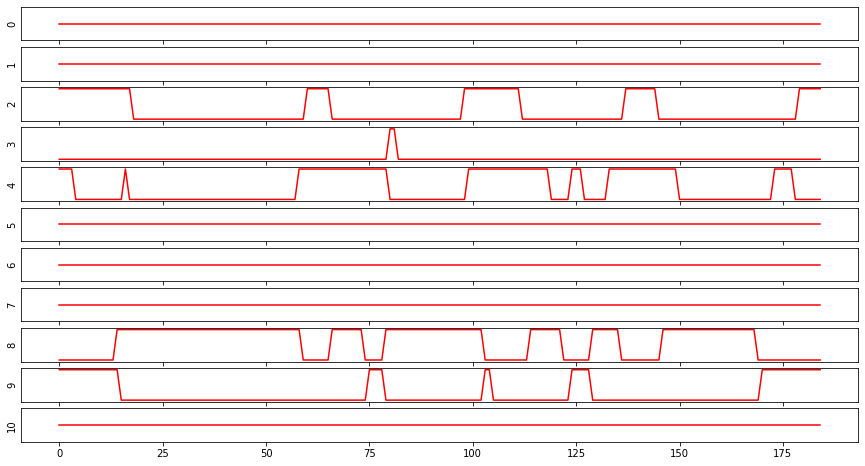

In [117]:
TEMP = process_file('test/speech_clean.wav', hparams, inference_mode=True)

# prediction on audio:
pred, processed = prediction_on_audio(TEMP['data'], hparams, 5)

# plot eventroll:
ff, aa = plt.subplots(11, 1, figsize=[15, 8])
for c in range(11):
    aa[c].plot(0.95 * processed[:, c], 'r')
    aa[c].set_yticks([])
    aa[c].set_ylabel(c)
plt.show()

In [116]:
Audio(filename='test/speech_clean.wav')

In [113]:
i2e

{0: 'Alarm_bell_ringing',
 1: 'Blender',
 2: 'Cat',
 3: 'Dishes',
 4: 'Dog',
 5: 'Electric_shaver_toothbrush',
 6: 'Frying',
 7: 'Running_water',
 8: 'Silence',
 9: 'Speech',
 10: 'Vacuum_cleaner'}

### Compare with Ground Truth:

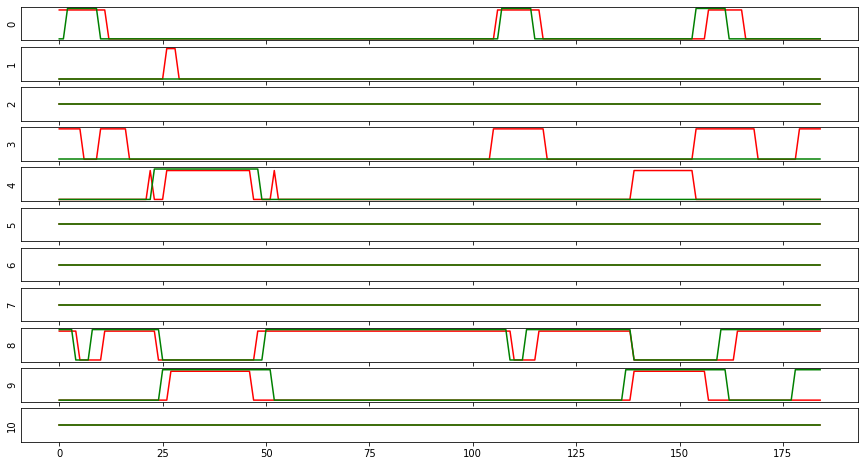

In [90]:
win = 5
temp = examples[7]

# prediction on audio:
pred, processed = prediction_on_audio(temp['data'], hparams, win)

res = []
for i in range(0, temp['target'].shape[0] - 50, 5):
    res += [(temp['target'][i:i+50, :].sum(axis=0) > 20)]
res = np.array(res)

# plot eventroll:
ff, aa = plt.subplots(11, 1, figsize=[15, 8])
for c in range(11):
    aa[c].plot(0.95 * processed[:, c], 'r')
    aa[c].plot(1.0 * res[2:-3, c], 'g')
    aa[c].set_yticks([])
    aa[c].set_ylabel(c)
plt.show()

In [38]:
def hamming_loss(y_pred, y_true):
    return 100 * (np.logical_xor(y_pred, y_true).sum() / np.prod(y_pred.shape))

In [43]:
acc = 0
ctr = 0
for example in examples[0:100]:

    # predicted label:
    pred, processed = prediction_on_audio(example['data'], 44100, win=3)

    # ground truth label:
    res = []
    for i in range(0, example['target'].shape[0] - 50, 10):
        res += [(example['target'][i:i+50, :].sum(axis=0) > 30)]
    res = np.array(res)

    # calculate hamming loss:
    hloss = hamming_loss(pred, res)
    print(f'example_number: {ctr}, Hamming Loss: {round(hloss, 2)} %')
    
    # increment counter:
    acc += hloss
    ctr += 1

example_number: 0, Hamming Loss: 8.13 %
example_number: 1, Hamming Loss: 11.67 %
example_number: 2, Hamming Loss: 13.68 %
example_number: 3, Hamming Loss: 12.82 %
example_number: 4, Hamming Loss: 15.31 %
example_number: 5, Hamming Loss: 13.4 %
example_number: 6, Hamming Loss: 10.91 %
example_number: 7, Hamming Loss: 13.59 %
example_number: 8, Hamming Loss: 13.49 %
example_number: 9, Hamming Loss: 14.45 %
example_number: 10, Hamming Loss: 12.92 %
example_number: 11, Hamming Loss: 12.54 %
example_number: 12, Hamming Loss: 16.27 %
example_number: 13, Hamming Loss: 16.27 %
example_number: 14, Hamming Loss: 15.31 %
example_number: 15, Hamming Loss: 13.3 %
example_number: 16, Hamming Loss: 12.73 %
example_number: 17, Hamming Loss: 15.5 %
example_number: 18, Hamming Loss: 12.82 %
example_number: 19, Hamming Loss: 13.88 %
example_number: 20, Hamming Loss: 13.97 %
example_number: 21, Hamming Loss: 13.78 %
example_number: 22, Hamming Loss: 12.63 %
example_number: 23, Hamming Loss: 13.88 %
exampl

In [44]:
print('Average hamming loss:', acc / 100)

Average hamming loss: 15.40669856459331
